# Variational Quantum Eigensolver Algorithm

The Variational Quantum Eigensolver (VQE) is a hybrid quantum-classical algorithm designed to estimate the ground state energy of a Hamiltonian 𝐻. The ground state energy is the smallest eigenvalue 𝜆 of the operator. Accurately finding this lowest energy state is a central task in quantum chemistry, physics, and materials science, where classical algorithms often struggle due to the exponential growth of the Hilbert space with system size.

In this notebook, we utilize IBM’s implementation of VQE, following the official IBM Quantum VQE tutorial. 
1. [Overview](#1.-Introduction)
2. [VQE Algorithm](#1.-Introduction)
3. [Qiskit Implementation](#3.-Quantum-Fourier-Transform)
4. [Execution](#5.-Execution)
5. [Post Processing](#6.-Post-Processing)

https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver

## 1. Overview

#### Problem Statement

This problem involves finding the minimum eigenvalue (ground state energy) of a given Hamiltonian efficiently.
Classically, diagonalizing large Hamiltonians is computationally expensive. VQE leverages quantum computing
and classical optimization to approximate the ground state energy by combining a quantum computer, which prepares quantum states and evaluates energy expectations and a classical optimizer, which adjusts parameters to minimize the energy.

Given a parameterized Hamiltonian $H(x)$ and a parameterized quantum state $\ket{\psi(\theta)}$:


$$
H\ket{\psi(\theta)} = \ket{\psi(\theta)}x
$$ 


The goal is to estimate the lowest eigenvalue $\lambda$. VQE defines a cost function as the expected value of the Hamiltonian in the ansatz state. VQE minimizes this function to find the ground state energy and optimal quantum state.

The expectation value is defined as: $E(\theta) = \ket{{\psi(\theta)}H{\psi}(\theta)}$

The VQE algorithm would then iteratively run the cost function using classical optimizers to find the minimum expectation value.





## 2. VQE Algorithm Steps:
1. Initialize parameters $\theta$
2. On a quantum computer:
    - Prepare state $\ket{\psi(\theta)} = U(\theta)\ket{0}$
    - Measure the energy $E(\theta)$
3. On  a classical computer, use optimizer (COBYLA, SPSA, etc.)

- Repeat steps 2-3 until convergence (minimum energy found)

## 3. Qiskit Implementation

#### 3.1 Imports

In [ ]:
%pip install numpy
%pip install qiskit
%pip install matplotlib
%pip install qiskit_ibm_runtime
%pip install qiskit_aer
%pip install qiskit[visualization]

In [7]:
# General imports
import numpy as np

# # Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator
    
from qiskit_algorithms.optimizers import COBYLA, SPSA
from qiskit_algorithms.utils import algorithm_globals
# from qiskit.primitives import Estimator, BaseEstimatorV2
from qiskit_ibm_runtime import SamplerV2, EstimatorV2
from qiskit_ibm_runtime import Session
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum") 
backend = service.backend("ibm_rensselaer")




### Example Hamiltonian

In [8]:
from qiskit.quantum_info import SparsePauliOp
#Example Hamiltonian 
hamiltonian = SparsePauliOp(['IIIIIIIIIIZZ', 'IIIIIIIIIZIZ', 'IIIIIIIIZIIZ', 'IIIIIIIZIIIZ', 'IIIIIIZIIIIZ', 'IIIIIZIIIIIZ', 'IIIIZIIIIIIZ', 'IIIZIIIIIIIZ', 'IIZIIIIIIIIZ', 'IZIIIIIIIIIZ', 'ZIIIIIIIIIIZ', 'IIIIIIIZIIZI', 'IIIIIIZIIIZI', 'IIIIIZIIIIZI', 'IIIZIIIIIIZI', 'IIZIIIIIIIZI', 'IZIIIIIIIIZI', 'IIIIZIIIIZII', 'ZIIIIIIIZIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 2.5+0.j, 2.5+0.j, 2.5+0.j, 0.5+0.j, 2.5+0.j,
 2.5+0.j, 2.5+0.j, 0.5+0.j, 2.5+0.j, 2.5+0.j, 2.5+0.j, 2.5+0.j, 2.5+0.j,
 2.5+0.j, 0.5+0.j, 0.5+0.j])

### Parametrized Ansatz
In the Variational Quantum Eigensolver algorithm, the ansatz is a quantum circuit used to approximate the ground state of a given Hamiltonian. A parametrized ansatz is a quantum circuit with tunable parameters — typically rotation angles — that define a family of quantum states.


In [ ]:
from qiskit.circuit.library import TwoLocal

ansatz = TwoLocal(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")


In [12]:
num_params = ansatz.num_parameters
num_params

0

### ISA Circuit
The ISA circuit is a transpiled form of the original ansatz, adapted to match the hardware constraints of a specific quantum backend. It is generated using a preset pass manager that optimizes the circuit based on the backend's qubit connectivity and native gate set. This ensures the circuit is both executable and efficient on the target quantum device.



In [11]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

### ISA observable
The ISA observable is the Hamiltonian transformed to align with the qubit layout used in the ISA circuit. This layout remapping ensures that measurements correspond correctly to the physical qubits on the hardware. It maintains consistency between the ansatz execution and energy evaluation during VQE.

In [13]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

#### Cost function

The cost function in VQE evaluates the expected energy of a quantum state prepared by a parameterized ansatz. It is called repeatedly by a classical optimizer to explore different parameter values and find the minimum energy configuration. This iterative process aims to approximate the ground state energy of a given Hamiltonian.`

In [ ]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [15]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [16]:
x0 = 2 * np.pi * np.random.random(num_params)

## 5. Execution
In the execution step, a session is started on the target backend, and an Estimator is initialized to evaluate the energy of the parameterized ISA circuit. The classical optimizer minimize then iteratively calls the cost function to find the parameter values that minimize the expectation value of the ISA-transformed Hamiltonian.

In [ ]:
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
        options={"maxiter": 10},
    )

## 6. Post-Processing

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

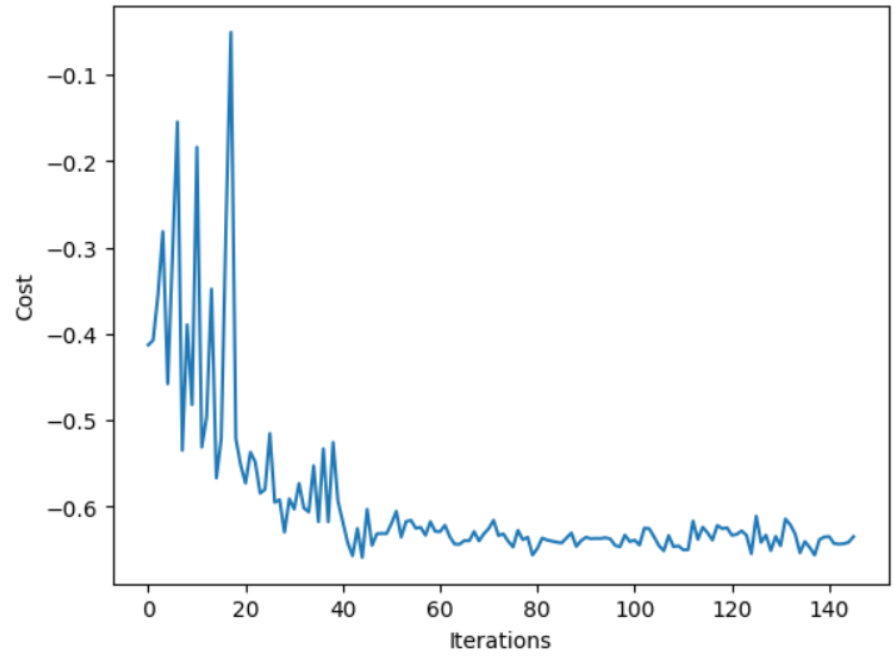